# Figure 6 Decoding Performance vs. latent uncertainty


In [1]:
import gc
import os
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import scipy.stats as stats

from maskedvae.plotting.plotting import (make_col_dict_monkey,get_title_dict,cm2inch)
from maskedvae.model.networks import apply_mask
from maskedvae.utils.evaluate import (
    infer_latents_monkey,
    train_on_all_obs,
    predict_and_evaluate,
)
from maskedvae.utils.utils import gpu, scale_datasets, copy_and_shuffle




fontsize=10
plt.rcParams.update({'font.size': fontsize})
plt.rcParams.update({'axes.spines.right': False})
plt.rcParams.update({'axes.spines.top': False})
plt.rcParams.update({'xtick.labelsize': fontsize})
plt.rcParams.update({'ytick.labelsize': fontsize})
plt.rcParams.update({'axes.titlesize': fontsize})
plt.rcParams.update({'axes.labelsize': fontsize})
plt.rcParams.update({'legend.fontsize': fontsize})
  

# specify the directory here where runs are stored
temp_dir = "../../runs/monkey/"

maskedloss=True
new_date=True

col_dict = make_col_dict_monkey()
title_dict = get_title_dict()

# reload the developing code 
%load_ext autoreload
%autoreload 2


In [ ]:
run_files = "./R_all_obs_40_mixed_extended.txt"
# load run_dirs from a text file
with open(run_files, "r") as f:
    run_dirs = f.readlines()
run_dirs = [x.strip() for x in run_dirs]

dimwise = True
cross_loss = False
beta_val = 1
nll_beta = 0.3

selected_runs_masked = []
selected_runs_all_obs = []
latents = "_lat_40"
full_mask_prob = 0.2
for run in run_dirs:

    if latents in run:
        with open(temp_dir + run + "/args.pkl", "rb") as f:
            args = pickle.load(f)
        if len(args.run_params["outputs"]) == 1:
            if "all_obs" in run:
                # all observed naive runs
                selected_runs_all_obs.append(run)
            else:
                # check if 0.2 or 0.5 all observed chance
                if args.run_params["full_mask_prob"] == full_mask_prob:
                    selected_runs_masked.append(run)


run_dirs = selected_runs_masked + selected_runs_all_obs

In [ ]:
tag_dim = "dimwise" if dimwise else "no_dimwise"
date_tag = datetime.now().strftime("%d%m%y").replace(".", "_")
tag_cross = "cross_loss" if cross_loss else "no_cross_loss"
tag_cross = date_tag + "_" + tag_cross


local_dir = "../../data/monkey/"

# make dires if they dont exist
if not os.path.exists(local_dir):
    os.makedirs(local_dir)
if not os.path.exists(local_dir + "figures/"):
    os.makedirs(local_dir + "figures/")


# check how many masked and naive runs are available
count_masked = 0
count_naive = 0
for run in run_dirs:
    count_masked += 1 if "masked" in run else 0
    count_naive += 1 if "all_obs" in run else 0
print(f"count_masked: {count_masked}, count_naive: {count_naive}")

if count_naive > count_masked:
    run_dirs = run_dirs[: 2 * count_masked]


# get the modeltags naive and run names
model_tags = []
run_names = []

for q, run in enumerate(run_dirs):
    run_names.append(run)
    if "all_obs" in run:
        model_tags.append("naive")
    elif "masked" in run:
        model_tags.append("masked")

count_masked: 10, count_naive: 10


# Evaluate the masked latents for all runs loading each model

In [ ]:
t_min = 100
t_max = 300
lat_mask = None
inp_mask = ("xa_s",)
test_masks = [
    "all_obs",
    "xa_m_5",
    "xa_m_20",
    "xa_m_50",
    "xa_m_100",
    "xa_m_150",
    "xa_m_200",
]

# specify the colors for the different masks
reds = plt.get_cmap("Reds")(np.linspace(0.3, 0.95, len(test_masks)))
blues = plt.get_cmap("Blues")(np.linspace(0.3, 0.95, len(test_masks)))

# load the data
data_dir = "../../data/monkey/"
with open(data_dir + "/PD_train.pkl", "rb") as f:
    PD_train = pickle.load(f)
with open(data_dir + "/PD_valid.pkl", "rb") as f:
    PD_valid = pickle.load(f)
with open(data_dir + "/PD_test.pkl", "rb") as f:
    PD_test = pickle.load(f)

# Loop over q values (assuming you have a list `run_dirs` and `model_tags`)
spikes_matrices = []
latent_means_masked = []
latent_stds_masked = []
latent_means_naive = []
latent_stds_naive = []
# loop over the runs and load the model and pass the masked test data through the model
for q in range(len(run_dirs)):
    exp_dir = temp_dir + run_dirs[q] + "/"

    with open(exp_dir + "model.pkl", "rb") as f:
        model = torch.load(f)

    session_data = PD_test.get_session(
        0, to_gpu=True, t_slice=model.eval_params["t_slice_test"]
    )

    if lat_mask is None:
        lat_mask = gpu(torch.ones(model.net.n_latents))

    # Run network
    latent_means = []
    latent_stds = []
    t = 0
    # standardize the the behavioral data - here no output behavior is used
    for k in model.net.scaling:
        if model.net.ifdimwise_scaling:
            for ii in range(session_data[k].shape[1]):
                session_data[k][:, ii] = model.net.dimwise_scaling[k + str(ii)][t][
                    0
                ] * (
                    session_data[k][:, ii]
                    - model.net.dimwise_scaling[k + str(ii)][t][1]
                )
        else:
            session_data[k] = model.net.scaling[k][t][0] * (
                session_data[k] - model.net.scaling[k][t][1]
            )  # Scale traces for training
        print(k, "Scaled... ")

    model_tag = "naive" if model.full_mask == 1 else "masked"
    # select different test masks

    for mask_key in test_masks:
        # if the mask has not been generated for the model, skip
        if mask_key not in model.masks.keys() and mask_key != "all_obs":
            print(mask_key + " not in model.masks.keys() or mask_key != all_obs")
            continue
        # for all masks that are part of the model pass the mask as train_mask (multiplies the mask with the input)
        if mask_key != "all_obs":
            print(mask_key, "Masked... ")
            network_outputs = model.net.encode(
                session_data,
                train_mask=model.masks[mask_key][: model.net.n_inputs],
                inp_mask=inp_mask,
            )
            masked_spikes = apply_mask(
                model,
                session_data,
                train_mask=model.masks[mask_key][: model.net.n_inputs],
                inp_mask=inp_mask,
            )
            if q == 0:
                spikes_matrices.append(masked_spikes[0].detach().cpu().numpy())
        else:  # for all observed train_mask is None and masking step is skipped
            print("all_observed")
            network_outputs = model.net.encode(session_data, inp_mask=inp_mask)
            masked_spikes = apply_mask(model, session_data, inp_mask=inp_mask)
            if q == 0:
                spikes_matrices.append(masked_spikes[0].detach().cpu().numpy())

        latent_means.append(network_outputs["z_mu"].detach().cpu().numpy())
        latent_stds.append(torch.exp(network_outputs["z_lsig"]).detach().cpu().numpy())
    # append the latent means and stds to the respective lists
    if model_tag == "masked":
        latent_means_masked.append(latent_means)
        latent_stds_masked.append(latent_stds)
    else:
        latent_means_naive.append(latent_means)
        latent_stds_naive.append(latent_stds)

# Figure 6 Panel B & C:
### B: Masked neural population activity for different masking level
### C: corresponding inferred latents of masked and naive VAEs 

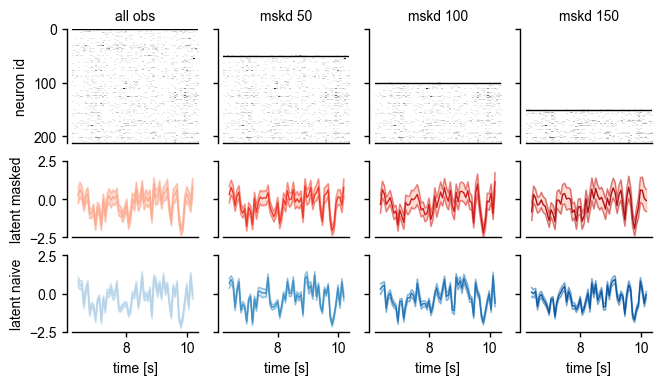

In [5]:
# Define the indices for the test masks you want to plot
plot_test_masks = [
    "all_obs",
    "xa_m_50",
    "xa_m_100",
    "xa_m_150",
]

masked_vals = [
    0,
    50,
    100,
    150,
]


# Specify time and latent index for the latent_means plot
t_min, t_max = 100, 160  # example time window (adjust according to your data)

q_masked, q_naive = 3, 3  # example run indices to plot
limval = 2.5
# list the latent indices sorted by variance highest first
sorted_indices_m = np.argsort(
    np.std(latent_means_masked[q_masked][0][0, :, t_min:t_max], axis=1)
)[::-1]
latent_index_m = sorted_indices_m[0]  # example latent index to plot

# list the latent indices sorted by variance highest first
sorted_indices_n = np.argsort(
    np.std(latent_means_naive[q_naive][0][0, :, t_min:t_max], axis=1)
)[::-1]
latent_index_n = sorted_indices_n[0]  # example latent index to plot

# Prepare the figure layout
fig, axs = plt.subplots(
    3,
    4,
    figsize=cm2inch(19, 10),
    gridspec_kw={"height_ratios": [1.5, 1, 1]},
    sharey="row",
)
# make the y axis of the last two rows the same
axs[1, 0].set_ylim(-limval, limval)
axs[2, 0].set_ylim(-limval, limval)


# Iterate over the 4 test masks and plot the corresponding spike trains and latent means
for mm, mask in enumerate(plot_test_masks):

    # get the index the mask would have in the test_masks list
    mask_index = test_masks.index(mask)

    # Plot spike trains (top row)
    ax_spike = axs[0, mm]
    ax_spike.imshow(
        spikes_matrices[mask_index][:, t_min:t_max], aspect="auto", cmap="Greys"
    )
    # get the number of masked neurons and draw a black line to separate them
    ax_spike.axhline(y=masked_vals[mm], color="black", linestyle="-")

    title = mask.replace("_", " ").replace("xa m", "mskd")
    ax_spike.set_title(title)
    ax_spike.set_xticks([])

    # Plot latent means with std band (bottom row 1)
    ax_latent_mean = axs[1, mm]
    latent_mean = latent_means_masked[q_masked][mask_index][
        0, latent_index_m, t_min:t_max
    ]
    latent_std = latent_stds_masked[q_masked][mask_index][
        0, latent_index_m, t_min:t_max
    ]
    time = np.arange(t_min, t_max) / model.fps

    ax_latent_mean.plot(time, latent_mean, label=mask, color=reds[mask_index])
    ax_latent_mean.fill_between(
        time,
        latent_mean - latent_std,
        latent_mean + latent_std,
        color=reds[1],
        alpha=0.3,
    )
    ax_latent_mean.plot(
        time, latent_mean - latent_std, color=reds[mask_index], alpha=0.5
    )
    ax_latent_mean.plot(
        time, latent_mean + latent_std, color=reds[mask_index], alpha=0.5
    )
    # ax_latent_mean.set_xlabel('time')
    ax_latent_mean.set_xticks([])
    # Plot latent means naive
    ax_latent_mean = axs[2, mm]
    latent_mean = latent_means_naive[q_naive][mask_index][
        0, latent_index_n, t_min:t_max
    ]
    latent_std = latent_stds_naive[q_naive][mask_index][0, latent_index_n, t_min:t_max]
    # time = np.arange(t_min, t_max)

    ax_latent_mean.plot(time, latent_mean, label=mask, color=blues[mask_index])
    ax_latent_mean.fill_between(
        time,
        latent_mean - latent_std,
        latent_mean + latent_std,
        color=blues[1],
        alpha=0.3,
    )
    ax_latent_mean.plot(
        time, latent_mean - latent_std, color=blues[mask_index], alpha=0.5
    )
    ax_latent_mean.plot(
        time, latent_mean + latent_std, color=blues[mask_index], alpha=0.5
    )

    ax_latent_mean.set_xlabel("time [s]")

axs[0, 0].set_ylabel("neuron id")
axs[1, 0].set_ylabel("latent masked")
axs[2, 0].set_ylabel("latent naive")
for ax in axs.flatten():
    ax.spines["left"].set_position(("outward", 4))

# Adjust layout
# plt.tight_layout()
plt.savefig(
    f"{local_dir}/figures/latent_mean_std_masked_vs_naive_{q_masked}_{q_naive}.png",
    bbox_inches="tight",
)
plt.savefig(
    f"{local_dir}/figures/latent_mean_std_masked_vs_naive_{q_masked}_{q_naive}.pdf",
    bbox_inches="tight",
)

# Figure 6 Panel D:
### Distribution of latent uncertainty for all masking levels

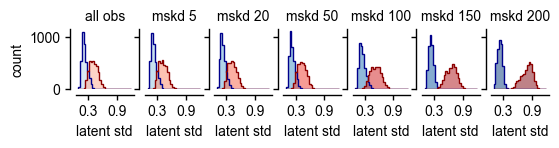

In [6]:
# ------------------------------------------------------
#
# plot the histograms of the latent stds
#
# ------------------------------------------------------


fig, ax = plt.subplots(
    1, len(test_masks), figsize=cm2inch(15.5, 2), sharey=True, sharex=True
)
ax = ax.flatten()
bins = np.linspace(0.1, 1.2, 31)
t_min, t_max = 50, 10000
for mask_index in range(len(test_masks)):
    ax[mask_index].hist(
        latent_stds_naive[q_naive][mask_index][0, latent_index_n, t_min:t_max],
        bins=bins,
        color="darkblue",
        histtype="step",
        lw=1,
    )
    ax[mask_index].hist(
        latent_stds_masked[q_masked][mask_index][0, latent_index_m, t_min:t_max],
        bins=bins,
        color="darkred",
        histtype="step",
        lw=1,
    )
    ax[mask_index].hist(
        latent_stds_naive[q_naive][mask_index][0, latent_index_n, t_min:t_max],
        bins=bins,
        color=blues[mask_index],
        alpha=0.5,
    )
    ax[mask_index].hist(
        latent_stds_masked[q_masked][mask_index][0, latent_index_m, t_min:t_max],
        bins=bins,
        color=reds[mask_index],
        alpha=0.5,
    )

    ax[mask_index].set_title(
        test_masks[mask_index].replace("_", " ").replace("xa m", "mskd")
    )
    ax[mask_index].set_xlabel("latent std")
ax[0].set_xticks([0.3, 0.9])
ax[0].set_ylabel("count")
for axi in ax:
    axi.spines["left"].set_position(("outward", 4))
    axi.spines["bottom"].set_position(("outward", 4))

plt.savefig(
    f"{local_dir}/figures/latent_std_hist_masked_vs_naive_{q_masked}_{q_naive}.png",
    bbox_inches="tight",
)
plt.savefig(
    f"{local_dir}/figures/latent_std_hist_masked_vs_naive_{q_masked}_{q_naive}.pdf",
    bbox_inches="tight",
)

# Train a linear ridge regression model from latents to velocity

In [ ]:
# Define test masks
test_masks = [
    "all_obs",
    "xa_m_5",
    "xa_m_20",
    "xa_m_50",
    "xa_m_100",
    "xa_m_150",
    "xa_m_200",
]

arr = np.zeros(
    (len(run_dirs), len(test_masks), 4)
)  # q x mask x 4 (train, val, test, test_shuffle)

all_results = {
    metric: arr.copy()
    for metric in [
        "mean_r2",
        "v_x_r2",
        "v_y_r2",
        "v_x_rmse",
        "v_y_rmse",
        "v_x_corr",
        "v_y_corr",
    ]
}
all_results_spikes = {
    metric: arr.copy()
    for metric in [
        "mean_r2",
        "v_x_r2",
        "v_y_r2",
        "v_x_rmse",
        "v_y_rmse",
        "v_x_corr",
        "v_y_corr",
    ]
}

all_variances = np.zeros((len(run_dirs), len(test_masks), model.net.n_latents))
all_means = np.zeros((len(run_dirs), len(test_masks), model.net.n_latents))

selected_variances = np.zeros((len(run_dirs), len(test_masks)))
avg_latents = 1

for q in range(len(run_dirs)):
    exp_dir = temp_dir + run_dirs[q] + "/"

    with open(exp_dir + "model.pkl", "rb") as f:
        model = torch.load(f)

    # Decode latents for train, validation, and test sets
    train_latent_means, train_latent_stds, train_y, train_d, train_spikes_matrices = (
        infer_latents_monkey(PD_train, model, test_masks)
    )
    valid_latent_means, valid_latent_stds, valid_y, valid_d, valid_spikes_matrices = (
        infer_latents_monkey(PD_valid, model, test_masks)
    )
    test_latent_means, test_latent_stds, test_y, test_d, test_spikes_matrices = (
        infer_latents_monkey(PD_test, model, test_masks)
    )

    # standardize the means and the behavioral data

    sorted_indices = np.argsort(
        np.std(train_latent_means[test_masks.index("all_obs")][0], axis=-1)
    )[::-1]
    latent_indices = sorted_indices[:avg_latents]  # example latent index to plot
    # example usage
    scaled_data = scale_datasets(
        train_d,
        valid_d,
        test_d,
        train_latent_means,
        valid_latent_means,
        test_latent_means,
        train_spikes_matrices,
        valid_spikes_matrices,
        test_spikes_matrices,
        test_masks,
        standardize=False,
        min_max=True,
    )

    (
        train_d,
        valid_d,
        test_d,
        train_latent_means,
        valid_latent_means,
        test_latent_means,
        train_spikes_matrices,
        valid_spikes_matrices,
        test_spikes_matrices,
    ) = scaled_data

    # train the model on the all observed training data

    reg_x_means, reg_y_means = train_on_all_obs(
        train_latent_means[test_masks.index("all_obs")],
        train_d,
        delay=2,
        reg_type="ridge",
    )
    reg_x_d, reg_y_d = train_on_all_obs(train_d, train_d, delay=2, reg_type="ridge")
    reg_x_spikes, reg_y_spikes = train_on_all_obs(
        train_spikes_matrices[test_masks.index("all_obs")],
        train_d,
        delay=2,
        reg_type="ridge",
    )

    for mm, mask in enumerate(test_masks):

        all_variances[q, mm, :] = np.mean(train_latent_stds[mm], axis=-1)
        all_means[q, mm, :] = np.mean(train_latent_means[mm], axis=-1)
        selected_variances[q, mm] = np.mean(train_latent_stds[mm][0, latent_indices, :])
        print(np.mean(train_latent_stds[mm][0, latent_indices, :], axis=-1))
        # now predict and evaluate the models
        # latent means to velocity

        results_means_train = predict_and_evaluate(
            reg_x_means,
            reg_y_means,
            train_latent_means[test_masks.index(mask)],
            train_d,
            delay=2,
            print_shapes=True,
        )
        results_means_val = predict_and_evaluate(
            reg_x_means,
            reg_y_means,
            valid_latent_means[test_masks.index(mask)],
            valid_d,
            delay=2,
            print_shapes=True,
        )
        results_means_test = predict_and_evaluate(
            reg_x_means,
            reg_y_means,
            test_latent_means[test_masks.index(mask)],
            test_d,
            delay=2,
            print_shapes=True,
        )
        results_means_test_shuffle = predict_and_evaluate(
            reg_x_means,
            reg_y_means,
            test_latent_means[test_masks.index(mask)],
            copy_and_shuffle(test_d),
            delay=2,
            print_shapes=True,
        )

        for key in all_results.keys():
            all_results[key][q, mm, 0] = results_means_train[key]
            all_results[key][q, mm, 1] = results_means_val[key]
            all_results[key][q, mm, 2] = results_means_test[key]
            all_results[key][q, mm, 3] = results_means_test_shuffle[key]
        # spikes to velocity

        results_spikes_train = predict_and_evaluate(
            reg_x_spikes,
            reg_y_spikes,
            train_spikes_matrices[test_masks.index(mask)],
            train_d,
            delay=2,
            print_shapes=True,
        )
        results_spikes_val = predict_and_evaluate(
            reg_x_spikes,
            reg_y_spikes,
            valid_spikes_matrices[test_masks.index(mask)],
            valid_d,
            delay=2,
            print_shapes=True,
        )
        results_spikes_test = predict_and_evaluate(
            reg_x_spikes,
            reg_y_spikes,
            test_spikes_matrices[test_masks.index(mask)],
            test_d,
            delay=2,
            print_shapes=True,
        )
        results_spikes_test_shuffle = predict_and_evaluate(
            reg_x_spikes,
            reg_y_spikes,
            test_spikes_matrices[test_masks.index(mask)],
            copy_and_shuffle(test_d),
            delay=2,
            print_shapes=True,
        )

        for key in all_results_spikes.keys():
            all_results_spikes[key][q, mm, 0] = results_spikes_train[key]
            all_results_spikes[key][q, mm, 1] = results_spikes_val[key]
            all_results_spikes[key][q, mm, 2] = results_spikes_test[key]
            all_results_spikes[key][q, mm, 3] = results_spikes_test_shuffle[key]
        # reference model to check correctness velocity from velocity

    results_d_train = predict_and_evaluate(
        reg_x_d, reg_y_d, train_d, train_d, delay=2, print_shapes=True
    )
    results_d_val = predict_and_evaluate(
        reg_x_d, reg_y_d, valid_d, valid_d, delay=2, print_shapes=True
    )
    results_d_test = predict_and_evaluate(
        reg_x_d, reg_y_d, test_d, test_d, delay=2, print_shapes=True
    )
    results_d_test_shuffle = predict_and_evaluate(
        reg_x_d, reg_y_d, copy_and_shuffle(test_d), test_d, delay=2, print_shapes=True
    )

    print(model_tags[q])

# Figure 6 Panel E:
### Latent uncertainty vs. decoding performance for many model seeds fit with ridge regression

Naive Index 0 - Slope: 0.035, p-value: 0.458
Naive Index 1 - Slope: 0.179, p-value: 0.040
Naive Index 2 - Slope: 0.222, p-value: 0.002
Naive Index 3 - Slope: 0.068, p-value: 0.123
Naive Index 4 - Slope: 0.139, p-value: 0.139
Naive Index 5 - Slope: 0.035, p-value: 0.008
Naive Index 6 - Slope: 0.117, p-value: 0.158
Naive Index 7 - Slope: 0.079, p-value: 0.030
Naive Index 8 - Slope: 0.056, p-value: 0.217
Naive Index 9 - Slope: 0.039, p-value: 0.251
Masked Index 0 - Slope: -1.611, p-value: 0.001
Masked Index 1 - Slope: -1.718, p-value: 0.000
Masked Index 2 - Slope: -2.568, p-value: 0.003
Masked Index 3 - Slope: -2.186, p-value: 0.004
Masked Index 4 - Slope: -1.763, p-value: 0.004
Masked Index 5 - Slope: -2.225, p-value: 0.000
Masked Index 6 - Slope: -1.483, p-value: 0.000
Masked Index 7 - Slope: -1.801, p-value: 0.001
Masked Index 8 - Slope: -2.849, p-value: 0.000
Masked Index 9 - Slope: -1.651, p-value: 0.001


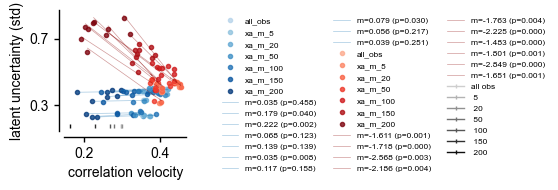

In [ ]:
plt.figure(figsize=cm2inch(4, 4))
metric = "v_y_corr"

greys = plt.get_cmap("Greys")(np.linspace(0.3, 0.95, len(test_masks)))

masked_indices = [i for i, x in enumerate(model_tags) if x == "masked"]
naive_indices = [i for i, x in enumerate(model_tags) if x == "naive"]
# loop through each naive index
for i, idx in enumerate(naive_indices):
    metric_naive = all_results[metric][idx, :, 2].flatten()
    std_naive = selected_variances[idx, :].flatten()

    # calculate slope, intercept, and p-value
    slope_naive, intercept_naive, r_value_naive, p_value_naive, std_err_naive = (
        stats.linregress(metric_naive, std_naive)
    )

    # plot data with linear fit
    for mm in range(len(test_masks)):
        plt.plot(
            metric_naive[mm],
            std_naive[mm],
            "o",
            ms=3,
            color=blues[mm],
            alpha=0.8,
            label=test_masks[mm] if (i == 0) else None,
        )
    plt.plot(
        metric_naive,
        slope_naive * metric_naive + intercept_naive,
        color="C0",
        alpha=0.4,
        lw=0.5,
        label=f"m={slope_naive:.3f} (p={p_value_naive:.3f})",
    )

    # print slope and p-value
    print(f"Naive Index {i} - Slope: {slope_naive:.3f}, p-value: {p_value_naive:.3f}")

# loop through each masked index
for i, idx in enumerate(masked_indices):
    metric_masked = all_results[metric][idx, :, 2].flatten()
    std_masked = selected_variances[idx, :].flatten()

    # calculate slope, intercept, and p-value
    slope_masked, intercept_masked, r_value_masked, p_value_masked, std_err_masked = (
        stats.linregress(metric_masked, std_masked)
    )

    # plot data with linear fit
    for mm in range(len(test_masks)):
        plt.plot(
            metric_masked[mm],
            std_masked[mm],
            "o",
            ms=3,
            color=reds[mm],
            alpha=0.8,
            label=test_masks[mm] if (i == 0) else None,
        )
    plt.plot(
        metric_masked,
        slope_masked * metric_masked + intercept_masked,
        alpha=0.4,
        lw=0.5,
        color="darkred",
        label=f"m={slope_masked:.3f} (p={p_value_masked:.3f})",
    )

    # add labels and legend
    plt.xlabel("correlation velocity")
    plt.ylabel("latent uncertainty (std)")

    # print slope and p-value
    print(
        f"Masked Index {i} - Slope: {slope_masked:.3f}, p-value: {p_value_masked:.3f}"
    )

# move outward
plt.gca().spines["left"].set_position(("outward", 4))
plt.gca().spines["bottom"].set_position(("outward", 4))


for mm, mask in enumerate(test_masks):
    plt.plot(
        all_results_spikes[metric][0, mm, 2],
        np.min(selected_variances) - 0.05,
        marker="|",
        color=greys[mm],
        markersize=3,
        label=mask.replace("_", " ").replace("xa m", ""),
        zorder=0,
    )

plt.yticks([0.3, 0.7])
plt.legend(loc="upper right", bbox_to_anchor=(4, 1), fontsize=6, ncols=3)
plt.savefig(
    f"{local_dir}/figures/{metric}_vs_uncertainty_linear_fit_avg_latents_{avg_latents}.png",
    bbox_inches="tight",
)
plt.savefig(
    f"{local_dir}/figures/{metric}_vs_uncertainty_linear_fit_avg_latents_{avg_latents}.pdf",
    bbox_inches="tight",
)